In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import six

from tensorflow.contrib import autograph
from tensorflow.contrib.eager.python import tfe
from tensorflow.python.eager import context


In [0]:
import gzip
import shutil

from six.moves import urllib


def download(directory, filename):
  filepath = os.path.join(directory, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(directory):
    tf.gfile.MakeDirs(directory)
  url = 'https://storage.googleapis.com/cvdf-datasets/mnist/' + filename + '.gz'
  zipped_filepath = filepath + '.gz'
  print('Downloading %s to %s' % (url, zipped_filepath))
  urllib.request.urlretrieve(url, zipped_filepath)
  with gzip.open(zipped_filepath, 'rb') as f_in, open(filepath, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
  os.remove(zipped_filepath)
  return filepath


def dataset(directory, images_file, labels_file):
  images_file = download(directory, images_file)
  labels_file = download(directory, labels_file)

  def decode_image(image):
    # Normalize from [0, 255] to [0.0, 1.0]
    image = tf.decode_raw(image, tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    return image / 255.0

  def decode_label(label):
    label = tf.decode_raw(label, tf.uint8)
    label = tf.reshape(label, [])
    return tf.to_int32(label)

  images = tf.data.FixedLengthRecordDataset(
      images_file, 28 * 28, header_bytes=16).map(decode_image)
  labels = tf.data.FixedLengthRecordDataset(
      labels_file, 1, header_bytes=8).map(decode_label)
  return tf.data.Dataset.zip((images, labels))


def mnist_train(directory):
  return dataset(directory, 'train-images-idx3-ubyte',
                 'train-labels-idx1-ubyte')

def mnist_test(directory):
  return dataset(directory, 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

def setup_mnist_data(is_training, hp, batch_size):
  if is_training:
    ds = mnist_train('/tmp/autograph_mnist_data')
    ds = ds.cache()
    ds = ds.shuffle(batch_size * 10)
  else:
    ds = mnist_test('/tmp/autograph_mnist_data')
    ds = ds.cache()
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  return ds


In [0]:
def mlp_model(input_shape):
  model = tf.keras.Sequential((
      tf.keras.layers.Dense(100, activation='relu', input_shape=input_shape),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')))
  model.build()
  return model


In [0]:
# Test-only parameters. Test checks successful completion not correctness. 
burn_ins = 1
trials = 1
max_steps = 2

In [0]:
#@test {"skip": true} 
burn_ins = 3
trials = 10
max_steps = 500

# Autograph

In [0]:
def predict(m, x, y):
  y_p = m(x)
  losses = tf.keras.losses.categorical_crossentropy(y, y_p)
  l = tf.reduce_mean(losses)
  accuracies = tf.keras.metrics.categorical_accuracy(y, y_p)
  accuracy = tf.reduce_mean(accuracies)
  return l, accuracy


In [0]:
def fit(m, x, y, opt):
  l, accuracy = predict(m, x, y)
  opt.minimize(l)
  return l, accuracy


In [0]:
def get_next_batch(ds):
  itr = ds.make_one_shot_iterator()
  image, label = itr.get_next()
  x = tf.to_float(tf.reshape(image, (-1, 28 * 28)))
  y = tf.one_hot(tf.squeeze(label), 10)
  return x, y


In [0]:
def train(train_ds, test_ds, hp):
  m = mlp_model((28 * 28,))
  opt = tf.train.MomentumOptimizer(hp.learning_rate, 0.9)
  train_losses = []
  train_losses = autograph.utils.set_element_type(train_losses, tf.float32)
  test_losses = []
  test_losses = autograph.utils.set_element_type(test_losses, tf.float32)
  train_accuracies = []
  train_accuracies = autograph.utils.set_element_type(train_accuracies,
                                                      tf.float32)
  test_accuracies = []
  test_accuracies = autograph.utils.set_element_type(test_accuracies,
                                                     tf.float32)
  i = tf.constant(0)
  while i < hp.max_steps:
    train_x, train_y = get_next_batch(train_ds)
    test_x, test_y = get_next_batch(test_ds)
    step_train_loss, step_train_accuracy = fit(m, train_x, train_y, opt)
    step_test_loss, step_test_accuracy = predict(m, test_x, test_y)

    train_losses.append(step_train_loss)
    test_losses.append(step_test_loss)
    train_accuracies.append(step_train_accuracy)
    test_accuracies.append(step_test_accuracy)
    i += 1
  return (autograph.stack(train_losses), autograph.stack(test_losses),  autograph.stack(train_accuracies),
          autograph.stack(test_accuracies))


Duration: 0.592790126801
Duration: 0.594069957733
Duration: 0.591835975647
Duration: 0.592386007309
Duration: 0.595040082932
Duration: 0.594245910645
Duration: 0.624264001846
Duration: 0.6021900177
Duration: 0.592960119247
Duration: 0.599496841431
Mean duration: 0.597927904129 +/- 0.0093268291102


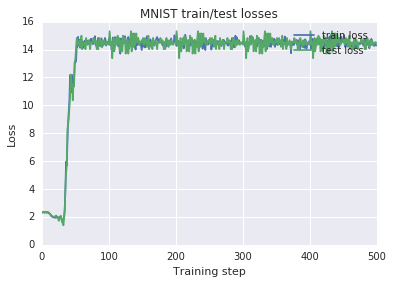

test_accuracy 0.1


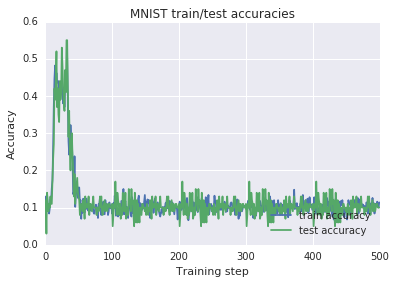

In [37]:
with tf.Graph().as_default():
  hp = tf.contrib.training.HParams(
      learning_rate=0.05,
      max_steps=max_steps,
  )
  train_ds = setup_mnist_data(True, hp, 500)
  test_ds = setup_mnist_data(False, hp, 100)
  tf_train = autograph.to_graph(train)
  (train_losses_, test_losses_, train_accuracies_,
   test_accuracies_) = tf_train(train_ds, test_ds, hp)

  with tf.Session() as sess:
    durations = []
    for t in range(burn_ins + trials):
      sess.run(tf.global_variables_initializer())
      start = time.time()
      (train_losses, test_losses, train_accuracies,
       test_accuracies) = sess.run([train_losses_, 
                                    test_losses_, 
                                    train_accuracies_,
                                    test_accuracies_])
      if t < burn_ins:
        continue
      duration = time.time() - start
      durations.append(duration)
      print('Duration:', duration)

    print('Mean duration:', np.mean(durations), '+/-', np.std(durations))
    plt.title('MNIST train/test losses')
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.xlabel('Training step')
    plt.ylabel('Loss')
    plt.show()
    plt.title('MNIST train/test accuracies')
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(test_accuracies, label='test accuracy')
    print('test_accuracy', test_accuracies[-1])
    plt.legend(loc='lower right')
    plt.xlabel('Training step')
    plt.ylabel('Accuracy')
    plt.show()


# Eager

In [0]:
def predict(m, x, y):
  y_p = m(x)
  losses = tf.keras.losses.categorical_crossentropy(tf.cast(y, tf.float32), y_p)
  l = tf.reduce_mean(losses)
  accuracies = tf.keras.metrics.categorical_accuracy(y, y_p)
  accuracy = tf.reduce_mean(accuracies)
  return l, accuracy


In [0]:
def train(ds, hp):
  m = mlp_model((28 * 28,))
  opt = tf.train.MomentumOptimizer(hp.learning_rate, 0.9)
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []
  i = 0
  train_test_itr = tfe.Iterator(ds)
  for (train_x, train_y), (test_x, test_y) in train_test_itr:
    train_x = tf.to_float(tf.reshape(train_x, (-1, 28 * 28)))
    train_y = tf.one_hot(tf.squeeze(train_y), 10)
    test_x = tf.to_float(tf.reshape(test_x, (-1, 28 * 28)))
    test_y = tf.one_hot(tf.squeeze(test_y), 10)
    if i > hp.max_steps:
      break
    with tf.GradientTape() as tape:
      step_train_loss, step_train_accuracy = predict(m, train_x, train_y)
    grad = tape.gradient(step_train_loss, m.variables)
    opt.apply_gradients(zip(grad, m.variables))
    step_test_loss, step_test_accuracy = predict(m, test_x, test_y)

    train_losses.append(step_train_loss)
    test_losses.append(step_test_loss)
    train_accuracies.append(step_train_accuracy)
    test_accuracies.append(step_test_accuracy)
    i += 1
  return train_losses, test_losses, train_accuracies, test_accuracies


Duration: 4.2232978344
Duration: 4.2386469841
Duration: 4.24286484718
Duration: 4.24036884308
Duration: 4.25758385658
Duration: 4.23242998123
Duration: 4.4213449955
Duration: 4.29613113403
Duration: 4.28209114075
Duration: 4.24192905426
Mean duration: 4.26766886711 +/- 0.055508619589


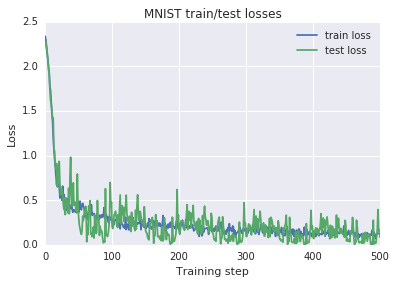

test_accuracy tf.Tensor(0.99, shape=(), dtype=float32)


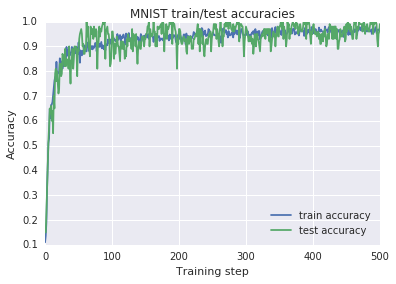

In [40]:
with context.eager_mode():
  durations = []
  for t in range(burn_ins + trials):
    hp = tf.contrib.training.HParams(
        learning_rate=0.05,
        max_steps=max_steps,
    )
    train_ds = setup_mnist_data(True, hp, 500)
    test_ds = setup_mnist_data(False, hp, 100)
    ds = tf.data.Dataset.zip((train_ds, test_ds))
    start = time.time()
    (train_losses, test_losses, train_accuracies,
     test_accuracies) = train(ds, hp)
    if t < burn_ins:
      continue
    train_losses[-1].numpy()
    test_losses[-1].numpy()
    train_accuracies[-1].numpy()
    test_accuracies[-1].numpy()
    duration = time.time() - start
    durations.append(duration)
    print('Duration:', duration)


  print('Mean duration:', np.mean(durations), '+/-', np.std(durations))
  plt.title('MNIST train/test losses')
  plt.plot(train_losses, label='train loss')
  plt.plot(test_losses, label='test loss')
  plt.legend()
  plt.xlabel('Training step')
  plt.ylabel('Loss')
  plt.show()
  plt.title('MNIST train/test accuracies')
  plt.plot(train_accuracies, label='train accuracy')
  plt.plot(test_accuracies, label='test accuracy')
  print('test_accuracy', test_accuracies[-1])
  plt.legend(loc='lower right')
  plt.xlabel('Training step')
  plt.ylabel('Accuracy')
  plt.show()
